In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds 

import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from wordcloud import WordCloud

# Lets load data first, for this problem we are going to use a text classification problem for multiclass
- imdb reviews
  - Contains only text
  - Contains labels such as ['pos', 'neg']

In [2]:
(train_ds, valid_ds, test_ds), ds_info = tfds.load(
    'imdb_reviews', split=['train', 'test[50%:]', 'test[:50%]'], as_supervised=True, with_info=True, data_dir='data'
)

Shuffling and writing examples to data/imdb_reviews/plain_text/1.0.0.incompleteFD8MGG/imdb_reviews-train.tfrecord


Shuffling and writing examples to data/imdb_reviews/plain_text/1.0.0.incompleteFD8MGG/imdb_reviews-test.tfrecord


Shuffling and writing examples to data/imdb_reviews/plain_text/1.0.0.incompleteFD8MGG/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to data/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
# Lets views some info of our dataset
ds_info.splits

{'test': <tfds.core.SplitInfo num_examples=25000>,
 'train': <tfds.core.SplitInfo num_examples=25000>,
 'unsupervised': <tfds.core.SplitInfo num_examples=50000>}

In [4]:
index_label = dict([(indx, label) for indx, label in enumerate(ds_info.features['label'].names)])
index_label

{0: 'neg', 1: 'pos'}

# Lets perform some eda - to understand our data
- Class Distribution
- Word to class Distribution
- Word Cloud

In [5]:
train_df = tfds.as_dataframe(train_ds, ds_info)

In [6]:
vals = train_df['label'].value_counts().values

<BarContainer object of 2 artists>

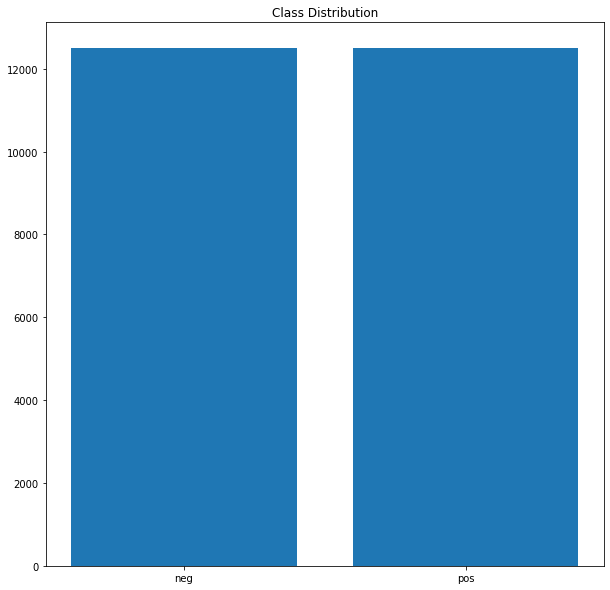

In [7]:
plt.figure(figsize=(10, 10))
plt.title('Class Distribution')
plt.bar(
  index_label.values(), vals
)

In [8]:
train_df['text_length'] = train_df['text'].apply(lambda x: len(x))
train_df['text_label'] = train_df['label'].apply(lambda x: index_label[x])

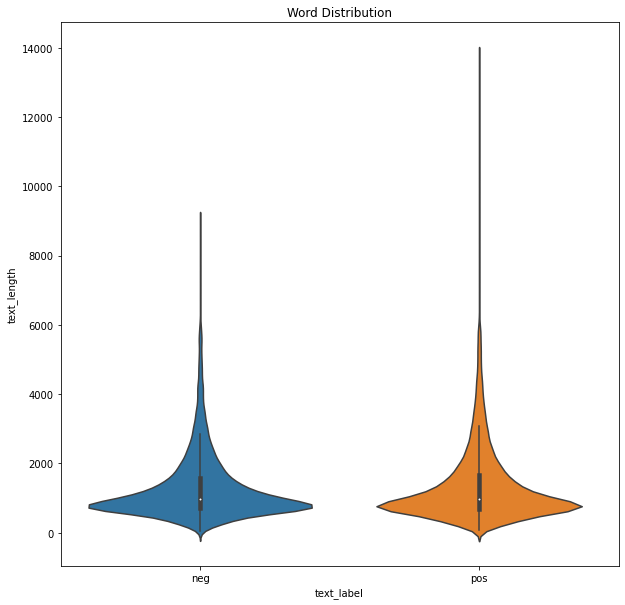

In [9]:
plt.figure(figsize=(10, 10))
plt.title('Word Distribution')
sns.violinplot(data=train_df, x='text_label', y='text_length')

In [10]:
text = ' '.join(train_df['text'].apply(lambda x: x.decode('utf-8')).values)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

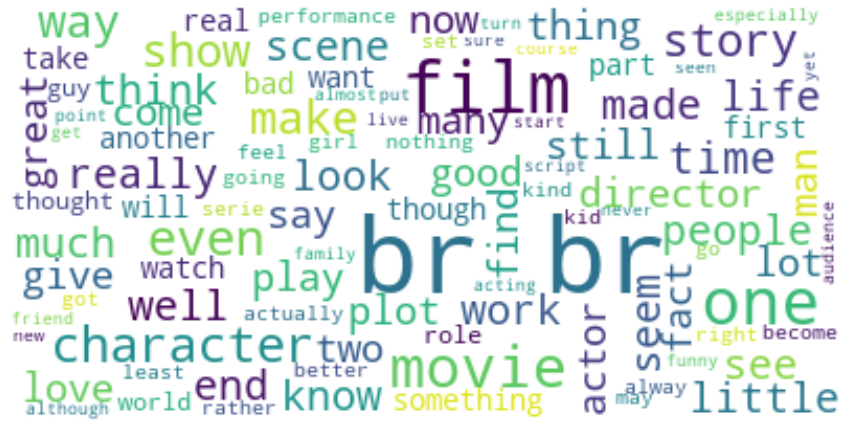

In [11]:
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Lets build our text encoder 
- We will use a text vectorization layer which function same as 2 other functions
  - tokenizer
  - pad sequences

In [12]:
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=1000, pad_to_max_tokens=True
)

In [13]:
encoder.adapt(train_ds.map(lambda text, label: text))

In [14]:
vocab = np.array(encoder.get_vocabulary())

In [15]:
for text, label in test_ds.take(5):
  encoded_text = encoder(text)
  print(vocab[encoded_text][:20])

['there' 'are' 'films' 'that' 'make' '[UNK]' 'for' 'george' '[UNK]' 'it'
 'was' 'night' 'of' 'the' 'living' 'dead' 'for' '[UNK]' '[UNK]' '[UNK]']
['a' '[UNK]' 'comic' 'tale' 'of' 'a' '[UNK]' '[UNK]' '[UNK]' '[UNK]' 'the'
 '[UNK]' 'that' '[UNK]' '[UNK]' 'was' 'able' 'to' '[UNK]' 'in']
['scary' 'movie' '[UNK]' '[UNK]' 'movie' '[UNK]' 'movie' 'meet' 'the'
 '[UNK]' 'not' 'another' '[UNK]' 'movie' 'and' 'another' '[UNK]' 'movie'
 'making' '[UNK]']
['poor' '[UNK]' '[UNK]' 'tries' 'hard' 'to' '[UNK]' 'some' '[UNK]' 'to'
 'this' '[UNK]' '[UNK]' '[UNK]' 'movie' 'but' 'shes' '[UNK]' 'by' 'the']
['as' 'a' '[UNK]' '[UNK]' '[UNK]' 'i' 'enjoyed' 'this' 'film' 'very'
 'much' 'it' 'was' 'so' 'realistic' 'and' 'funny' 'it' 'really' '[UNK]']


# Lets learn to map our dataset and prepare for training
- Not much to do here but shuffle and batch the dataset

In [16]:
train_ds = train_ds.shuffle(len(train_ds)).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.shuffle(len(test_ds)).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.shuffle(len(valid_ds)).batch(64).prefetch(tf.data.experimental.AUTOTUNE)

# Lets build our model
- We will use the sequential api

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(1, dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

In [19]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-8), metrics=['accuracy']
)

In [20]:
history = model.fit(train_ds, validation_data=valid_ds, epochs=10)

Epoch 1/10
391/391 [==============================] - 82s 165ms/step - loss: 0.6121 - accuracy: 0.6432 - val_loss: 0.3910 - val_accuracy: 0.8295
Epoch 2/10
391/391 [==============================] - 62s 155ms/step - loss: 0.3724 - accuracy: 0.8431 - val_loss: 0.3509 - val_accuracy: 0.8404
Epoch 3/10
391/391 [==============================] - 62s 155ms/step - loss: 0.3354 - accuracy: 0.8611 - val_loss: 0.3173 - val_accuracy: 0.8618
Epoch 4/10
391/391 [==============================] - 62s 155ms/step - loss: 0.3202 - accuracy: 0.8690 - val_loss: 0.3308 - val_accuracy: 0.8558
Epoch 5/10
391/391 [==============================] - 62s 155ms/step - loss: 0.3103 - accuracy: 0.8726 - val_loss: 0.3144 - val_accuracy: 0.8660
Epoch 6/10
391/391 [==============================] - 62s 156ms/step - loss: 0.3034 - accuracy: 0.8760 - val_loss: 0.3175 - val_accuracy: 0.8608
Epoch 7/10
391/391 [==============================] - 62s 156ms/step - loss: 0.2997 - accuracy: 0.8781 - val_loss: 0.3127 - val_ac

In [21]:
model.evaluate(test_ds)

196/196 [==============================] - 13s 63ms/step - loss: 0.3248 - accuracy: 0.8609


[0.3248452842235565, 0.8608800172805786]

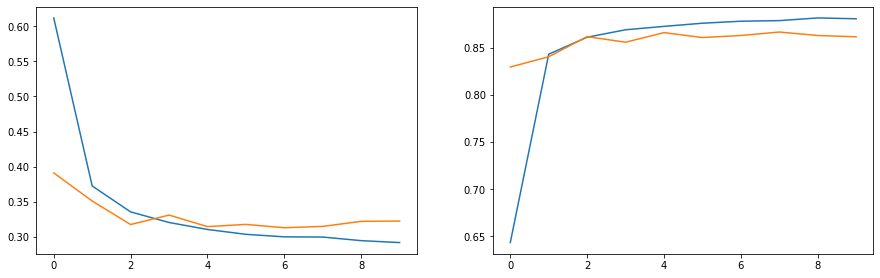

In [26]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.subplot(222)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

# Model Validation
- Lets validate our model with sckit learn

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef

In [27]:
test_df = tfds.as_dataframe(test_ds, ds_info)

In [34]:
y_true = np.concatenate(test_df['label'].values)
y_pred = model.predict(np.concatenate(test_df['text'].values)).argmax(axis=1)

In [37]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.82      0.86      6291
           1       0.83      0.90      0.87      6209

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500



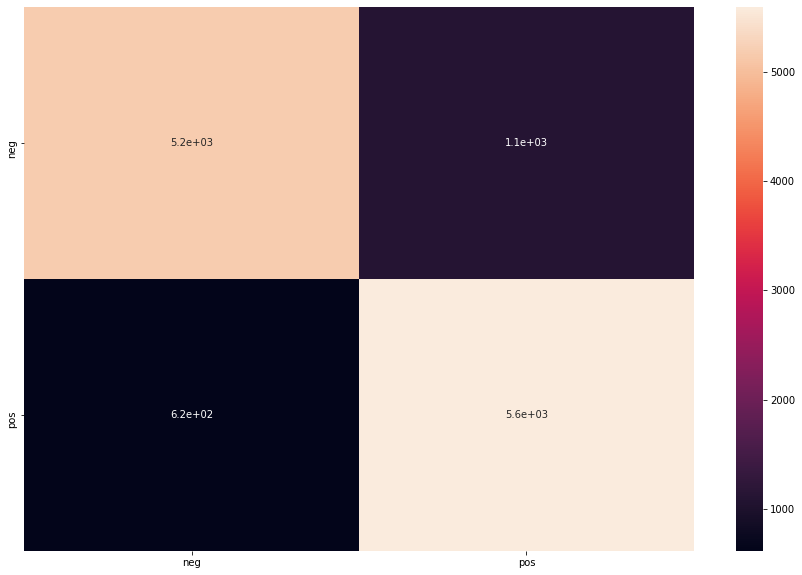

In [40]:
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, xticklabels=index_label.values(), yticklabels=index_label.values())

In [42]:
matthews_corrcoef(y_true, y_pred)

0.7242418554886516